# My ML experiments

In [3]:
from IPython.display import Image
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from time import time
from operator import itemgetter

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.cross_validation import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import VotingClassifier
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [971]:
# Code that extracts lagged stock data. This code calculates precentage differences between 'Adj Close' of TWO days,
# current and the previous one. It NOT pct change of 'open' and 'close' Adj Prices.
def create_lagged_series(symbol, start_date, end_date, lags=5):
    """This creates a pandas DataFrame that stores the percentage returns of the 
    adjusted closing value of a stock obtained from Yahoo Finance, along with 
    a number of lagged returns from the prior trading days (lags defaults to 5 days).
    Trading volume, as well as the Direction from the previous day, are also included."""

    # Obtain stock information from Yahoo Finance
    ts = web.DataReader(symbol, "yahoo", start_date-datetime.timedelta(days=365), end_date)
    
    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag["Today"] = ts["Adj Close"]
    tslag["Volume"] = ts["Volume"]

    # Create the shifted lag series of prior trading period close values
    for i in range(0,lags):
        tslag["Lag%s" % str(i+1)] = ts["Adj Close"].shift(i+1)

    # Create the returns DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    tsret["Volume"] = tslag["Volume"]
    tsret["Today"] = tslag["Today"].pct_change()*100.0

    # If any of the values of percentage returns equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(tsret["Today"]):
        if (abs(x) < 0.0001):
            tsret["Today"][i] = 0.0001

    # Create the lagged percentage returns columns
    for i in range(0,lags):
        tsret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)].pct_change()*100.0

    # Create the "Direction" column (+1 or -1) indicating an up/down day
    tsret["Direction"] = np.sign(tsret["Today"])
    tsret = tsret[tsret.index >= start_date]

    return tsret

In [973]:
msft2 = create_lagged_series('msft', datetime.datetime(2014, 12, 30), datetime.datetime(2015, 12, 31) )
msft2.head()

/Users/yo/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Volume,Today,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
Date,,,,,,,,
2014-12-30,16384700,-0.906218,-0.898079,-0.540088,-0.639838,0.979576,0.671423,-1
2014-12-31,21552500,-1.212249,-0.906218,-0.898079,-0.540088,-0.639838,0.979576,-1
2015-01-02,27913900,0.667378,-1.212249,-0.906218,-0.898079,-0.540088,-0.639838,1
2015-01-05,39673900,-0.919581,0.667378,-1.212249,-0.906218,-0.898079,-0.540088,-1
2015-01-06,36447900,-1.467733,-0.919581,0.667378,-1.212249,-0.906218,-0.898079,-1


In [151]:
# This code extracts 'open', 'close' and 'volume' and calculates pct change of the 'close' compared to 'open' price
# for the last three days
# extracting data with pandas_datareader
start = datetime.date(2014, 12, 30)
end = datetime.date(2015, 12, 31)
msft = web.DataReader('MSFT', "yahoo", start, end)
msft = msft[['Open', 'Close', 'Volume']].reset_index()

In [1028]:
# Addig previous three days prc change on the same row using .shift()
# calculating the positive or negative for today ( close - open)
# Adding a label (not used here) that takes value 1 or -1 depending on positive or negative prct change for today
msft['Today'] = ((msft.Close / msft.Open) - 1) * 100
msft['Lag1'] = ((msft['Close'].shift(1) / msft['Open'].shift(1)) - 1) * 100
msft['Lag2'] = ((msft['Close'].shift(2) / msft['Open'].shift(2)) - 1) * 100
msft['Lag3'] = ((msft['Close'].shift(3) / msft['Open'].shift(3)) - 1) * 100
msft['Lag4'] = ((msft['Close'].shift(3) / msft['Open'].shift(4)) - 1) * 100
msft['Lag5'] = ((msft['Close'].shift(3) / msft['Open'].shift(5)) - 1) * 100
msft['Direction_int'] = np.where(msft['Today']> 0, '1', '0')
# This how to drop columns from df
# msft.drop(msft.columns[8], axis=1, inplace=True)
msft.tail()

,Date,Open,Close,Volume,Today,Lag1,Lag2,Lag3,Direction_int,Lag4,Lag5
249,2015-12-24,55.860001,55.669998,9570000,-0.340141,0.215438,0.654657,-0.091106,0,-1.685490,-2.714689
250,2015-12-28,55.349998,55.950001,22458300,1.084016,-0.340141,0.215438,0.654657,1,0.856409,-0.753097
251,2015-12-29,56.290001,56.549999,27731400,0.461890,1.084016,-0.340141,0.215438,1,1.509362,1.712826
252,2015-12-30,56.470001,56.310001,21704500,-0.283336,0.461890,1.084016,-0.340141,0,-0.053865,1.236581
253,2015-12-31,56.040001,55.480000,27334100,-0.999288,-0.283336,0.461890,1.084016,0,0.161117,0.448833


In [691]:
# Creating tarining and testing pairs of predictor and target variables
feature_cols3 = ['Lag1', 'Lag2']
X3 = msft[2:][feature_cols3]
y3 = msft[2:].Direction_int
msft[(msft['Lag2'].isnull())]
msft.Direction_int = msft.Direction_int.astype(int)

In [692]:
# Conditional select part of the df where values in two columns are less than zero
# msft[(msft['T_1_pct'] < 0) & (msft['T_2_pct'] < 0)]
X3.shape, y3.shape

((252, 2), (252,))

In [693]:
# we use train_test_split() to separate the msft into train and test parts
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1)

In [694]:
# fitting/training the Linear Regression Model
# !!! Very important - it seems that in order to being able to pass data to the .fit() function, it has to be in 
# very specific shape. Apparently, it must be in a shape of numpy matrix or array with two dimensions at least.
# when checking the shape it can't be something like (199,) it has to be something like (1, 199) - meaning that
# it has 1 row and 199 columns. Also - the X and y data sets have to have first dimension aligned - the same
linreg3 = LinearRegression()
linreg3.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
# Predicting with Linear Regression Model. When using .predict() we only add one parameter, which is X_test dataset
y3_pred = linreg3.predict(X3_test)
# printing out the SRME, which is quite big here and it makes sense as markets are definitely not linearly connected
print(np.sqrt(metrics.mean_squared_error(y3_test, y3_pred)))
y3_pred, y_test, y3_test

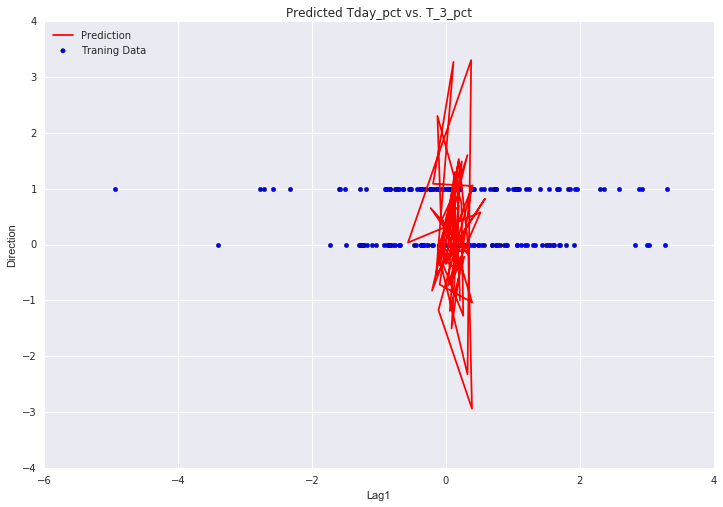

In [695]:
x3 = y3_pred.flatten()
f3 = y3_test.ravel()
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x1, f1, 'r', label='Prediction')
ax.scatter(X3_train.Lag1, y3_train, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Lag1')
ax.set_ylabel('Direction')
ax.set_title('Predicted Tday_pct vs. T_3_pct')

# Linear Regression example from book 'Mastering Machine Learning with scikit-learn' (page 21)

In [388]:
# example from 'Mastering Machine Learning with scikit-learn'
#pizza_data = pd.read_clipboard()
pizza_data

,Diameter,Price
0,6,7.0
1,8,9.0
2,10,13.0
3,14,17.5
4,18,18.0


In [594]:
X = pizza_data.Diameter.to_frame() # converting it to frame as it seems .fit() from sklearn has to have frame or matrix
# for the X_train data
y = pizza_data.Price
# they need to have the same 1st column
X.shape,y.shape
np.matrix(X)

matrix([[ 6],
        [ 8],
        [10],
        [14],
        [18]])

In [1356]:
# here I'm checking what type of data is created if I follow the book's code exactly. It's a list
Xp = [[6], [8], [10], [14], [18]]
yp = [[7.0], [9.0], [13.0], [17.5], [18.0]]

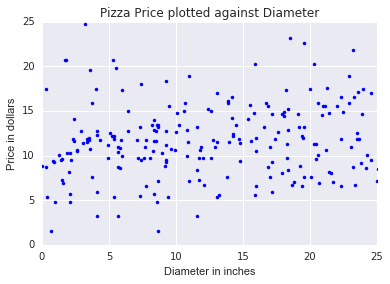

In [1357]:
# We plot the data here. the parameter 'k.' or 'b.' are colors. (For some reason here 'color='k' doesn't work)
plt.figure()
plt.title('Pizza Price plotted against Diameter')
plt.xlabel('Diameter in inches')
plt.ylabel('Price in dollars')
plt.plot(X, y, 'b.')
plt.axis([0,25,0,25])
plt.grid(True)
plt.show()

In [1358]:
# Our training data are X and y
# Create/instantiate the model
model = LinearRegression()
# here we fit the model - we train the model passing 1 predictor variable X and 1 target variable y. they both have
# the same 1st dimension and the same # of rows.
model.fit(X,y)
# need to be careful to input values for prediction. It's ok if it's just one number. In this case you can input
# as you want, but there are multiple values,they need to go in the form of list of lists or np.matrix
model.predict([12])
print('A 12" pizza should cost: $%.2f' % model.predict([12])[0])

ValueError: shapes (1,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

# This is exercise from the kaggle.blog Video #6

In [472]:
# Exercises from kaggle.blog video #6
data = pd.read_csv("/Users/yo/Documents/Books/Machine_Learning/ISLR/ISLR-python/Notebooks/Data/Advertising.csv", index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [1003]:
data['Sales'].shape

(200,)

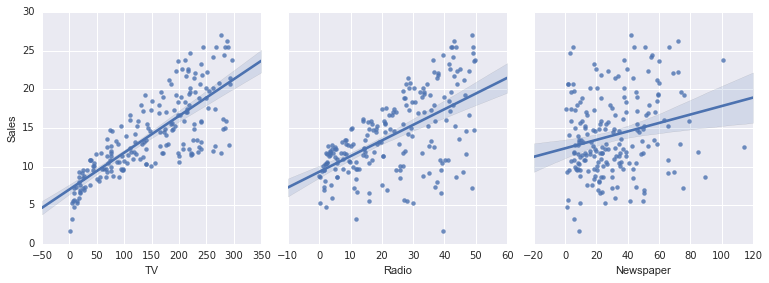

In [480]:
# visualise a pair of each feature(TV, Radio, Newspaper) and the target variable y - 'Sales' 
sns.pairplot(data, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', size=4, aspect=0.9, kind='reg')

In [602]:
# creating a lost of column names we need.
feature_cols = ['TV', 'Radio', 'Newspaper']
# aplying the columns names to the data, so we extract only the columns we need
X = data[feature_cols]
# equivalent
X = data[['TV', 'Radio', 'Newspaper']]
X.head()

,TV,Radio,Newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4


In [504]:
type(X), X.shape

(pandas.core.frame.DataFrame, (200, 3))

In [610]:
y = data.Sales
y.shape

(200,)

In [509]:
# Splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [510]:
# by default, the train to test split is 75% to 25%
print('',X_train.shape,'\n',X_test.shape,'\n',y_train.shape,'\n',y_test.shape, '\n')

 (150, 3) 
 (50, 3) 
 (150,) 
 (50,) 



In [517]:
# in this case, the train with predictors is pandas df and y set of targets is pandas Series, which have the 1st
# the same 1st column lengh
type(y_train), type(X_train)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [1359]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [520]:
# intercept is the Beta 0 parameter of the Linear Regression. Cost function and coeficients are Beta 1, Beta 2 and Beta 3
linreg.intercept_, linreg.coef_

(2.8769666223179335, array([ 0.04656457,  0.17915812,  0.00345046]))

In [1355]:
# in Python 3 I need to wrap the zip() into list() so I can see the actual results
list(zip(feature_cols, linreg.coef_))

TypeError: 'list' object is not callable

In [529]:
# After we learnt/fit the model with the training dataset, we're making prediction with the test dataset
y_pred = linreg.predict(X_test)

In [533]:
# examples of evaluation metrics for Linear Regression
# Mean Absolute error
true = [100, 50, 30, 20]
pred = [90, 50, 50, 30]

# MAE by hand
MAE = (abs(100 - 90) + abs(50 - 50) + abs(30 - 50) + abs(20 - 30)) / 4
print(MAE)

# calculating with sklearn
from sklearn import metrics
metrics.mean_absolute_error(true, pred)

10.0


10.0

In [545]:
# Next evaluation metrics is Mean Squared Error
# by hand
print((10**2 + 0**2 + 20**2 + 10**2)/4)
# MSE with sklearn 
MSE2 = metrics.mean_squared_error(true, pred)
MSE2

150.0


150.0

In [555]:
# RMSE - Root mean squared error
# by hand
print(np.sqrt((10**2 + 0**2 + 20**2 + 10**2)/4))
# with sklearn
print(np.sqrt(metrics.mean_squared_error(true, pred)))

12.2474487139
12.2474487139


In [599]:
# RMSE for our Sales prediction
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1.40465142303


In [612]:
# now we will remove the 'Newspaper' feature from our dataset as it looked from the graphs that it didn't have any 
# correlation with 'Sales'. the idea is to check if the RMSE error metric will improve without 'Newspaper' feature.
feature_cols2 = ['TV', 'Radio']
X2 = data[feature_cols2]
X2.shape, y.shape
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=1)

In [613]:
linreg2 = LinearRegression()
linreg2.fit(X2_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [617]:
# We see here that the RMSE got smaller - 1.38 instead of 1.40. It means that by removing the 'Newspaper' feature
# we improved the prediction
y2_pred = linreg2.predict(X2_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y2_pred)))

1.38790346994


# Logistic Regression experiments based on Coursera ML course - week 3. With stock data

In [1070]:
# Using the same msft data from above. I split the data into those days that y3 is up or down
# extracting data with pandas_datareader
start = datetime.date(2015, 12, 30)
end = datetime.date(2016, 12, 31)
nugt = web.DataReader('nugt', "yahoo", start, end)
nugt = nugt[['Open', 'Close', 'Volume']].reset_index()

nugt['Today'] = ((nugt.Close / nugt.Open) - 1) * 100
nugt['Lag1'] = ((nugt['Close'].shift(1) / nugt['Open'].shift(1)) - 1) * 100
nugt['Lag2'] = ((nugt['Close'].shift(2) / nugt['Open'].shift(2)) - 1) * 100
nugt['Lag3'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(3)) - 1) * 100
nugt['Lag4'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(4)) - 1) * 100
nugt['Lag5'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(5)) - 1) * 100
nugt['Lag6'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(6)) - 1) * 100
nugt['Lag7'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(7)) - 1) * 100
nugt['Lag8'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(8)) - 1) * 100
nugt['Lag9'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(9)) - 1) * 100
nugt['Lag10'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(10)) - 1) * 100
nugt['Lag11'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(11)) - 1) * 100
nugt['Lag12'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(12)) - 1) * 100
nugt['Lag13'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(13)) - 1) * 100
nugt['Lag14'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(14)) - 1) * 100
nugt['Lag15'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(15)) - 1) * 100
nugt['Lag16'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(16)) - 1) * 100
nugt['Lag17'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(17)) - 1) * 100
nugt['Lag18'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(18)) - 1) * 100
nugt['Lag19'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(19)) - 1) * 100
nugt['Lag20'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(20)) - 1) * 100
nugt['Lag21'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(21)) - 1) * 100
nugt['Lag22'] = ((nugt['Close'].shift(3) / nugt['Open'].shift(22)) - 1) * 100


nugt['Direction_int'] = np.where(nugt['Today']> 0, 1, 0).astype(int)
# msft.Direction_int = msft.Direction_int.astype(int)

In [1074]:
print(nugt.corr())

                   Open     Close    Volume     Today      Lag1      Lag2  \
Open           1.000000  0.992873 -0.434221 -0.068778  0.046797  0.047263   
Close          0.992873  1.000000 -0.426041  0.033047  0.034967  0.040355   
Volume        -0.434221 -0.426041  1.000000  0.085865  0.105874 -0.049903   
Today         -0.068778  0.033047  0.085865  1.000000 -0.093673 -0.028652   
Lag1           0.046797  0.034967  0.105874 -0.093673  1.000000 -0.093601   
Lag2           0.047263  0.040355 -0.049903 -0.028652 -0.093601  1.000000   
Lag3           0.038009  0.042338  0.027362  0.040191 -0.031137 -0.093514   
Lag4           0.101397  0.106532  0.069232  0.060127 -0.060373 -0.013261   
Lag5           0.132475  0.140813  0.089237  0.123605 -0.021408 -0.046343   
Lag6           0.163099  0.162392  0.099219 -0.005378  0.039854 -0.019568   
Lag7           0.180452  0.184536  0.088350  0.050026 -0.055981  0.040319   
Lag8           0.197934  0.206129  0.139685  0.066340  0.001944 -0.053827   

In [1360]:
# Using the same msft data from above. I split the data into those days that y3 is up or down
# extracting data with pandas_datareader
start = datetime.date(2010, 12, 30)
end = datetime.date(2015, 12, 31)
msft1 = web.DataReader('MSFT', "yahoo", start, end)
msft1 = msft1[['Open', 'Close', 'Volume']].reset_index()

msft1['Today'] = ((msft1.Close / msft1.Open) - 1) * 100
msft1['Lag1'] = ((msft1['Close'].shift(1) / msft1['Open'].shift(1)) - 1) * 100
msft1['Lag2'] = ((msft1['Close'].shift(2) / msft1['Open'].shift(2)) - 1) * 100
msft1['Lag3'] = ((msft1['Close'].shift(3) / msft1['Open'].shift(3)) - 1) * 100
# msft['T_1date'] = msft.Date.shift(1)
# msft['T_2date'] = msft.Date.shift(2)

msft1['Direction_int'] = np.where(msft1['Today']> 0, 1, 0)

# This how to drop columns from df
#msft.drop(msft.columns[4], axis=1, inplace=True)

In [1025]:
msft1 = msft1[['Lag1', 'Lag2', 'Direction_int']]
msft1.head()
#msft1[msft1.Direction_int.isin([1])]

,Lag1,Lag2,Direction_int
0,NaN,NaN,0
1,-0.250716,NaN,1
2,0.395687,-0.250716,0
3,-0.249551,0.395687,1
4,0.536861,-0.249551,1


In [848]:
msft1[msft1['Direction_int'].isin([0])].head()

,Lag1,Lag2,Direction_int
0,NaN,NaN,0
2,0.395687,-0.250716,0
6,2.781737,0.358423,0
7,-0.139661,2.781737,0
8,-0.141546,-0.139661,0


In [751]:
up.Lag2.min()

-4.933049095607222

/Users/yo/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


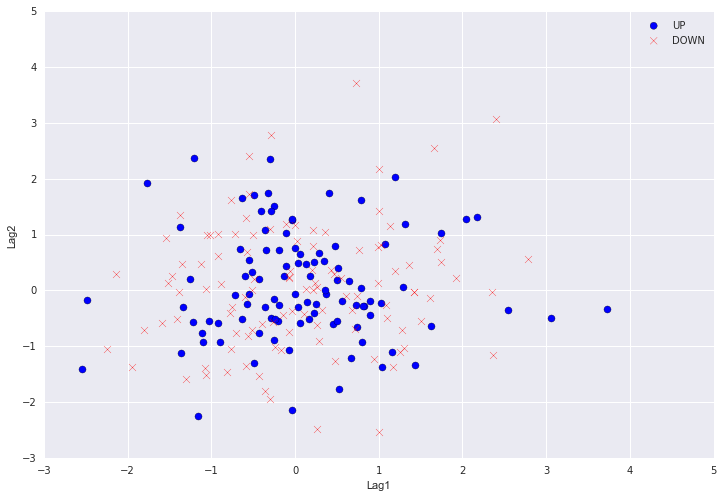

In [1361]:
# .isin notation let us access the cells with certain values and select them. In this case we separate the cases
# where Direction_int is 0 from 1
up = msft1[423:634][msft1['Direction_int'].isin([1])]
down = msft1[423:634][msft1['Direction_int'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(up['Lag1'], up['Lag2'], s=50, c='b', marker='o', label='UP')
ax.scatter(down['Lag1'], down['Lag2'], s=50, c='r', marker='x', label='DOWN')
ax.legend()
ax.set_xlabel('Lag1')
ax.set_ylabel('Lag2')

# Working with Smarket data from book ISLR - Chapter 4

In [1248]:
df.describe(include='all')
df.corr()
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [1362]:
df = pd.read_csv('/Users/yo/Documents/Books/Machine_Learning/ISLR/ISLR-python/Notebooks/Data/Smarket.csv',
                 usecols=range(1,10), index_col=0, parse_dates=True)
df.index = df.index.year
# df.drop(df['Dir_factor'], axis=1, inplace=True)

# X5_train = df.loc[2001 : 2005][['Lag1', 'Lag2']]
# y5_train = df.loc[2001 : 2005]['Direction']

# X5_test = df.loc[2005:2006][['Lag1', 'Lag2']]
# y5_test = df.loc[2005:2006]['Direction']
X5_train = df.loc[2001 : 2005][df.columns[:6]]
y5_train = df.loc[2001 : 2005][df.columns[-1]]

X5_test = df.loc[2005:2006][df.columns[:6]]
y5_test = df.loc[2005:2006][df.columns[-1]]
# df.index = df.index.year
# df['Dir_factor'] = df.Direction.factorize(1)[0]
print(X5_train.shape)
print(y5_train.shape)

print(X5_test.shape)
print(y5_test.shape)
X5 = df[df.columns[:6]]
y5 = df[df.columns[-1]]

X6_train = X5_train[X5_train.columns[:2]]
X6_test = X5_test[X5_train.columns[:2]]
y6_train = y5_train
y6_test = y5_test
y6_test.shape

(1250, 6)
(1250,)
(252, 6)
(252,)


(252,)

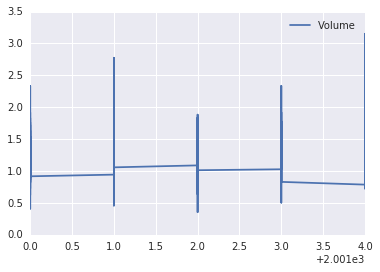

In [1250]:
df.plot(x=df.index, y='Volume')

In [1306]:
logreg = LogisticRegression(C=1000.0, random_state=0)
logreg.fit(X5_train, y5_train)

logreg6 = LogisticRegression(C=1000.0, random_state=0)
logreg6.fit(X6_train, y6_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0)

In [1307]:
print(logreg6.coef_)
print(logreg6.intercept_)

[[-0.07150998 -0.04449584]]
[ 0.07424965]


In [1275]:
probs = logreg.predict_proba(X5)
[prob[0] for prob in probs[0:5]]

[0.49224404242800657,
 0.51791234595174662,
 0.51852092054856902,
 0.48438968775858493,
 0.48865012972825517]

In [1276]:
ypreds = ["Up" if prob[0] > 0.5 else "Down" for prob in probs]
ypreds[0:5]

['Down', 'Up', 'Up', 'Down', 'Down']

In [1309]:
predict_logreg = logreg.predict(X5_test)
print(confusion_matrix(y5_test, predict_logreg))
print(classification_report(y5_test, predict_logreg, digits=3))
logreg.predict([-0.623, 1.032, 0.959, 0.381, -0.192, 1.2760])

#######
predict_logreg6 = logreg6.predict(X6_test)
print(confusion_matrix(y6_test, predict_logreg6))
print(classification_report(y6_test, predict_logreg6, digits=3))

[[  4 107]
 [  1 140]]
             precision    recall  f1-score   support

       Down      0.800     0.036     0.069       111
         Up      0.567     0.993     0.722       141

avg / total      0.670     0.571     0.434       252

[[  9 102]
 [  9 132]]
             precision    recall  f1-score   support

       Down      0.500     0.081     0.140       111
         Up      0.564     0.936     0.704       141

avg / total      0.536     0.560     0.455       252



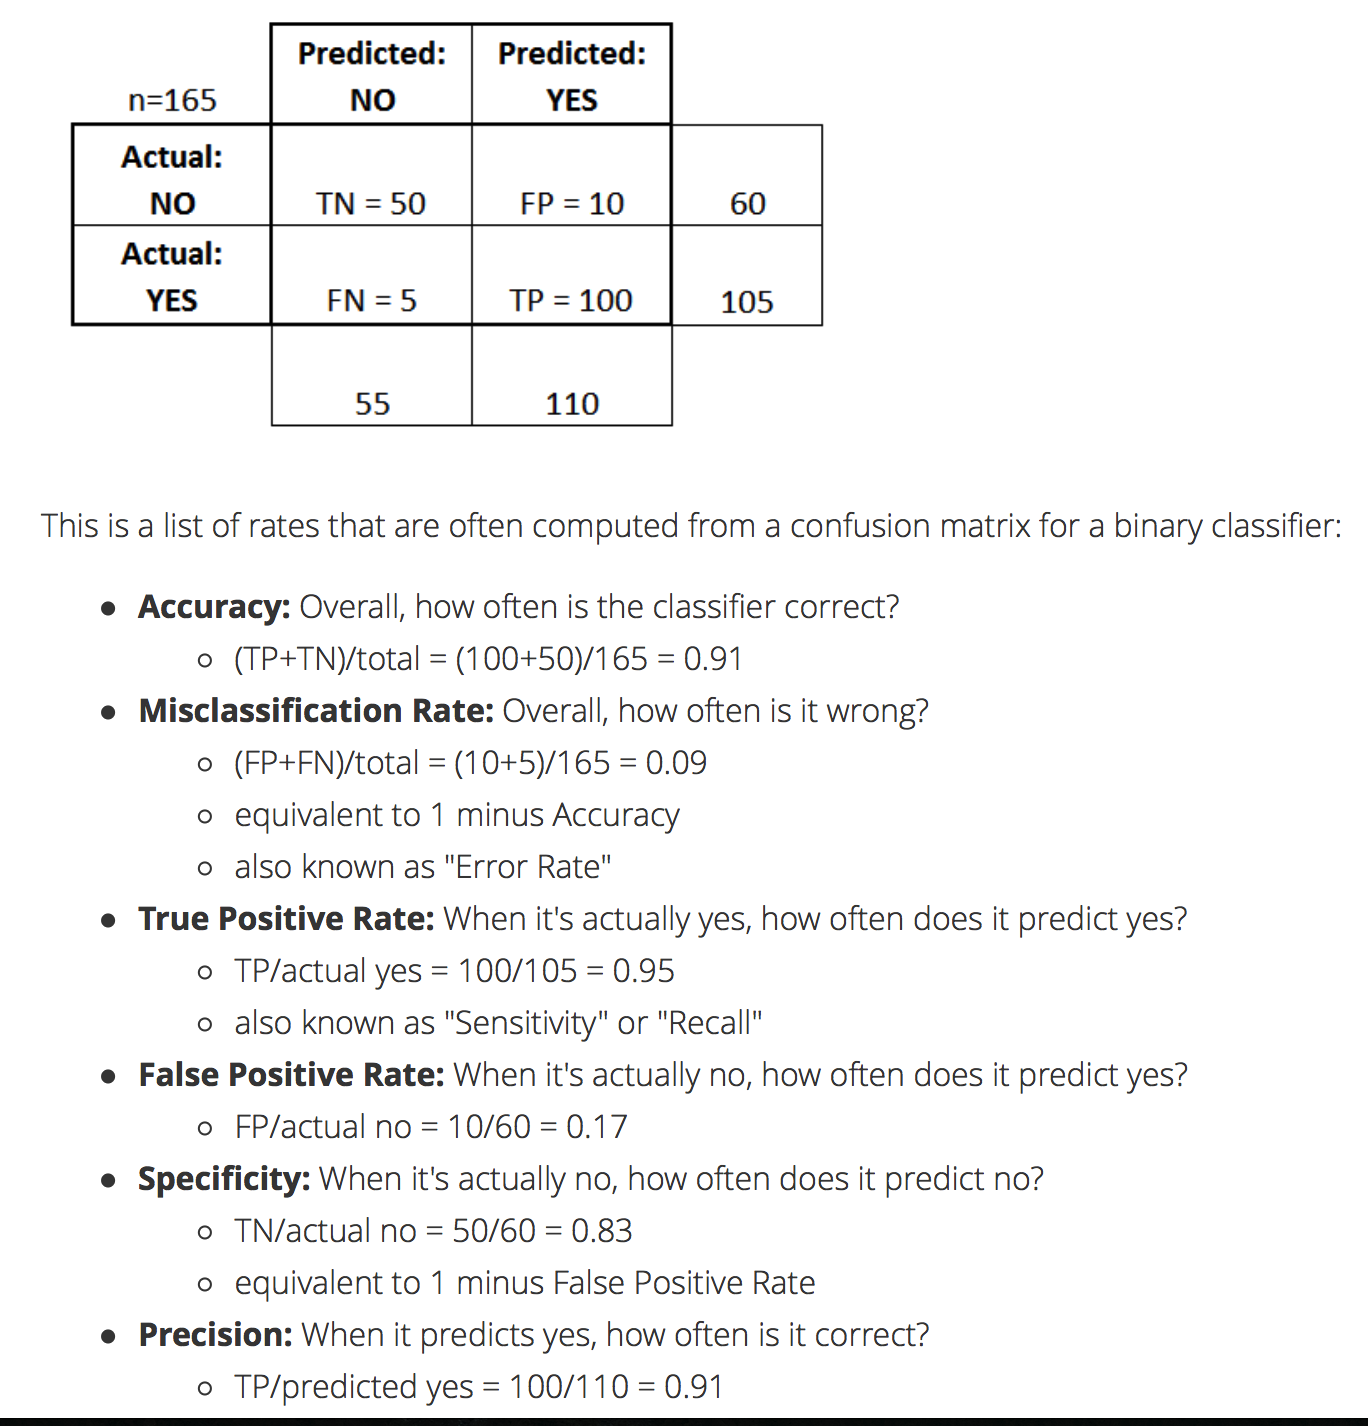

In [1318]:
PATH = "/Users/yo/Documents/Dev/ML_lab/img/"
Image(filename = PATH + "conf_matrix.png", width=600, height=600)

# Logistic Regression from ISLR but with my stock data

/Users/yo/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


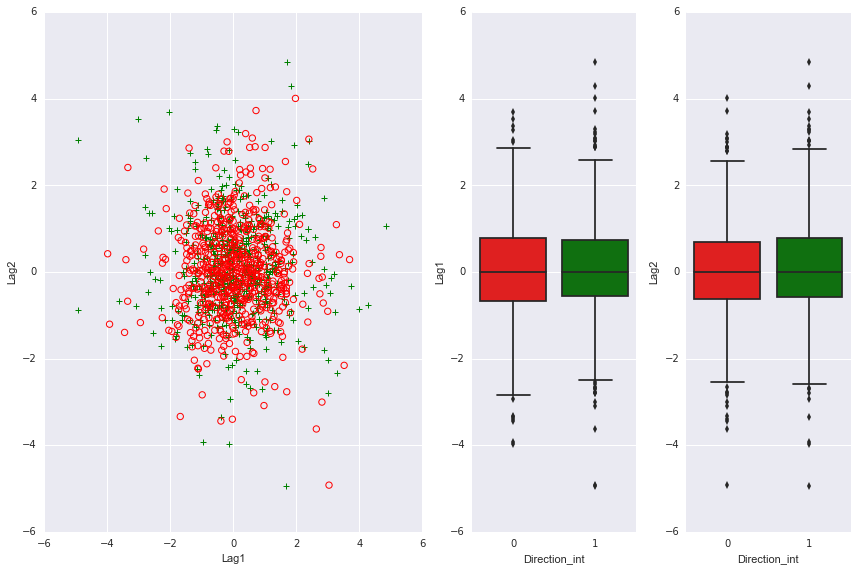

In [1363]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
up = msft1[2:][msft1['Direction_int'].isin([1])]
down = msft1[2:][msft1['Direction_int'].isin([0])]

ax1.scatter(up.Lag1, up.Lag2, s=40, c='green', marker='+',
            linewidths=1)
ax1.scatter(down.Lag1, down.Lag2, s=40, marker='o', linewidths='1',
            edgecolors='red', facecolors='none')

ax1.set_xlim(xmin=-6)
ax1.set_xlabel('Lag1')
ax1.set_ylim(ymin=-6)
ax1.set_ylabel('Lag2')


c_palette = {0:'red', 1:'green'}
sns.boxplot('Direction_int', 'Lag1', data=msft1, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('Direction_int', 'Lag2', data=msft1, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

In [785]:
X3.shape, y3.shape

((3, 2), (3,))

In [1364]:
feature_cols3 = ['Lag1', 'Lag2']
X3 = msft1[2:][feature_cols3]
y3 = msft1[2:].Direction_int

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1)

In [1365]:
classifier = LogisticRegression(C=1000.0, random_state=0)
classifier.fit(X3_train, y3_train)
predictions = classifier.predict(X3_test)
for i, prediction in enumerate(predictions[:5]):
    print('Prediction: %s. Lag1 &  Lag2 combo: %s' % (prediction, X3_test.values[i]))

Prediction: 0. Lag1 &  Lag2 combo: [-1.5739521 -0.0862562]
Prediction: 1. Lag1 &  Lag2 combo: [ 1.16226191  0.96564116]
Prediction: 1. Lag1 &  Lag2 combo: [ 1.33373441  0.21896153]
Prediction: 0. Lag1 &  Lag2 combo: [ 0.10671647 -0.42537754]
Prediction: 1. Lag1 &  Lag2 combo: [ 1.37374833  0.43754322]


In [1366]:
classifier.intercept_, classifier.coef_

(array([-0.03488003]), array([[ 0.04980966,  0.05866625]]))

In [1367]:
X3_train_const_lag1 = sm.add_constant(msft1[2:].Lag1)
type(X3_train_const_lag1)
est = smf.Logit(y3.ravel(), X3_train_const_lag1).fit()
est.summary().tables[1]
# The z value is very close to zero, it means that the Lag1 infcluence on the result of Up or Down day is nonexistant.
# Also the p value is not tiny, so this theory is correct.

Optimization terminated successfully.
         Current function value: 0.693084
         Iterations 3


,coef,std err,z,P>|z|,[95.0% Conf. Int.]
const,-0.0224,0.056,-0.397,0.691,-0.133 0.088
Lag1,0.0025,0.050,0.050,0.960,-0.095 0.100


In [1368]:
X3_train_const_lag2 = sm.add_constant(msft1[2:].Lag2)
est_lag2 = smf.Logit(y3.ravel(), X3_train_const_lag2).fit()
est_lag2.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.692549
         Iterations 3


,coef,std err,z,P>|z|,[95.0% Conf. Int.]
const,-0.0263,0.057,-0.465,0.642,-0.137 0.085
Lag2,0.0580,0.050,1.160,0.246,-0.040 0.156


In [1369]:
X3_train_alllogs = sm.add_constant(msft1[2:][['Lag1', 'Lag2']])
est = smf.Logit(y3, X3_train_alllogs).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.692547
         Iterations 3


,coef,std err,z,P>|z|,[95.0% Conf. Int.]
const,-0.0265,0.057,-0.468,0.640,-0.138 0.084
Lag1,0.0034,0.050,0.069,0.945,-0.094 0.101
Lag2,0.0581,0.050,1.161,0.246,-0.040 0.156


In [1246]:
confusion_matrix(y3_test, predictions),
print(metrics.classification_report(y3_test, predictions))
# the result of the confusion matrix is that we have 50% guessed right and wrong....well...keep searching..
# Confusion Matrix explanation http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/


             precision    recall  f1-score   support

          0       0.50      0.65      0.56       158
          1       0.49      0.34      0.40       157

avg / total       0.49      0.50      0.48       315



In [1247]:
print("Testing Accuracy : ",classifier.score(X3_test, y3_test)*100)

Testing Accuracy :  49.5238095238


## Different ML models through scikit-leran. It was found in a Github notebook

# Ridge Classifier

In [830]:
ridge = RidgeClassifierCV(alphas = np.logspace(0, 1, num=1000))
ridge.fit(X3_train, y3_train)

RidgeClassifierCV(alphas=array([  1.     ,   1.00231, ...,   9.97698,  10.     ]),
         class_weight=None, cv=None, fit_intercept=True, normalize=False,
         scoring=None)

In [949]:
ridge.score(X3_test, y3_test)
#ridge.predict(X3_test)

0.49841269841269842

# Gaussian Naive Bayes

In [844]:
gaussian = GaussianNB()
gaussian.fit(X3_train, y3_train)
gaussian.score(X3_test, y3_test)

0.46984126984126984

# K Nearest Neighbors - KNN

In [834]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [1347]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
list(range(1,41))

In [2]:
# build a classifier
knn = KNeighborsClassifier()

# grid over parameters
param_grid = {"metric": ["minkowski", "manhattan", "chebyshev"], 
              "n_neighbors": list(range(1,41)),
              "weights": ["uniform", "distance"]}

# run grid search
grid_search = GridSearchCV(knn, param_grid=param_grid, cv = 178)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

NameError: name 'KNeighborsClassifier' is not defined

In [845]:
knn = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', weights = 'distance')
knn.fit(X3_train, y3_train)
knn.score(X3_test, y3_test)

0.50158730158730158

# SVM

In [846]:
# build a classifier
svc = SVC()

# grid over parameters
param_grid = {"kernel": ["linear", "rbf", "sigmoid"],
              "gamma": [1e-3, 1e-4],
              "C": [1, 10, 100, 1000]}
                    
# run grid search
grid_search = GridSearchCV(svc, param_grid=param_grid, cv = 5)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 10.20 seconds for 24 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.515 (std: 0.037)
Parameters: {'gamma': 0.001, 'kernel': 'sigmoid', 'C': 1000}

Model with rank: 2
Mean validation score: 0.512 (std: 0.018)
Parameters: {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}

Model with rank: 3
Mean validation score: 0.511 (std: 0.033)
Parameters: {'gamma': 0.001, 'kernel': 'linear', 'C': 1}



In [847]:
svc = SVC(kernel = 'sigmoid', C = 1000, gamma = 0.001)
svc.fit(X3_train, y3_train)
svc.score(X3_test, y3_test) 

0.50158730158730158

# Decision Tree Classifier

In [1344]:
# build a classifier
tree = DecisionTreeClassifier()

# grid over parameters
param_grid = {"max_depth": [3, None],
              "max_features": list(range(1,3)),
              "min_samples_split": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "criterion": ["gini", "entropy"]}
                    
# run grid search
grid_search = GridSearchCV(tree, param_grid=param_grid, cv = 5)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

TypeError: 'list' object is not callable

In [872]:
tree = DecisionTreeClassifier(max_features = 1, min_samples_split = 3, criterion = 'entropy', max_depth = None, min_samples_leaf = 1)
tree.fit(X3_train, y3_train)
tree.score(X3_test, y3_test) 

0.53015873015873016

In [873]:
tree.feature_importances_

array([ 0.48680482,  0.51319518])

# Ensemble Classifiers - Random Forest

In [1]:
# build a classifier
clf = RandomForestClassifier(n_estimators=500)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": list(range(1,3)),
              "min_samples_split": list(range(2,10)),
              "min_samples_leaf": list(range(2,10)),
              "bootstrap": [False],
              "criterion": ["entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X4_train, y4_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

NameError: name 'RandomForestClassifier' is not defined

In [874]:
random_forest = RandomForestClassifier(random_state=1, n_estimators=100, bootstrap = False, min_samples_leaf = 2,
                                       min_samples_split = 4, max_features = 2, max_depth = None, criterion = 'entropy')
random_forest.fit(X3_train, y3_train)
random_forest.score(X3_test, y3_test)

0.53650793650793649

In [1338]:
random_forest.feature_importances_

array([ 0.53787213,  0.46212787])

# Gradient Boosting

In [875]:
GB = GradientBoostingClassifier(n_estimators=100)

param_grid = {"loss" : ["deviance", "exponential"],
             "learning_rate": [0.1],
             "max_depth": [3, None],
             "min_samples_split": [3, 5, 8, 11, 14, 20],
             "min_samples_leaf": [8, 11, 14, 17, 20],
             "max_features": [2]}

# run grid search
grid_search = GridSearchCV(GB, param_grid=param_grid)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 44.79 seconds for 120 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.530 (std: 0.031)
Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 3, 'max_depth': 3, 'min_samples_leaf': 14, 'max_features': 2}

Model with rank: 2
Mean validation score: 0.530 (std: 0.031)
Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 5, 'max_depth': 3, 'min_samples_leaf': 14, 'max_features': 2}

Model with rank: 3
Mean validation score: 0.530 (std: 0.031)
Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 8, 'max_depth': 3, 'min_samples_leaf': 14, 'max_features': 2}



In [877]:
GB = GradientBoostingClassifier(n_estimators=100, loss = 'exponential', learning_rate = 0.1,
                                min_samples_leaf = 14, min_samples_split = 3, max_features = 2, max_depth = 3)
GB.fit(X3_train, y3_train)
GB.score(X3_test, y3_test) 

0.50476190476190474

In [879]:
GB.feature_importances_

array([ 0.52509717,  0.47490283])

# QDA

In [1337]:
qda = QDA()
qda.fit(X3_train, y3_train)
print(qda.score(X3_test, y3_test))
print(confusion_matrix(y3_test, qda.predict(X3_test)))
print(metrics.classification_report(y3_test, qda.predict(X3_test)))

0.444444444444
[[103  55]
 [120  37]]
             precision    recall  f1-score   support

          0       0.46      0.65      0.54       158
          1       0.40      0.24      0.30       157

avg / total       0.43      0.44      0.42       315



In [904]:
# using Smrket data from the ISLR book
data4 = pd.read_csv("/Users/yo/Documents/Books/Machine_Learning/ISLR/ISLR-python/Notebooks/Data/Smarket.csv")
X4 = data4[['Lag1', 'Lag2']]
y4 = data4['Direction']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=1)
X4_train.shape

(937, 2)

In [894]:
print(metrics.classification_report(y4_test, qda.predict(X4_test)))

             precision    recall  f1-score   support

       Down       0.76      0.08      0.15       158
         Up       0.51      0.97      0.67       155

avg / total       0.64      0.52      0.41       313



# Ada boost

In [895]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

#param_grid = {"base_estimator" : [DecisionTreeClassifier(), RidgeClassifierCV()],
#             "learning_rate": [0.01, 0.5, 0.1]}

param_grid = {"base_estimator" : [DecisionTreeClassifier(max_features = 2, min_samples_split = 3, criterion = 'entropy', 
                                                         max_depth = None, min_samples_leaf = 7)], 
              "learning_rate": np.logspace(-5, 0, num=20)}
             
# run grid search
grid_search = GridSearchCV(Ada, param_grid=param_grid)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 17.85 seconds for 20 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.521 (std: 0.017)
Parameters: {'learning_rate': 0.00037926901907322499, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_samples_leaf=7,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')}

Model with rank: 2
Mean validation score: 0.519 (std: 0.011)
Parameters: {'learning_rate': 0.00020691380811147902, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_samples_leaf=7,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')}

Model with rank: 3
Mean validation score: 0.516 (std: 0.008)
Parameters: {'learning_rate': 1.8329807108324375e-05, 'base_estimator': DecisionTr

In [897]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', 
                         base_estimator = DecisionTreeClassifier(max_features = 2, min_samples_split = 3, criterion = 'entropy', 
                                                         max_depth = None, min_samples_leaf = 7), learning_rate = 0.00037926901907322499)
Ada.fit(X3_train, y3_train)
Ada.score(X3_test, y3_test)

0.53333333333333333

In [952]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

#param_grid = {"base_estimator" : [DecisionTreeClassifier(), RidgeClassifierCV()],
#             "learning_rate": [0.01, 0.5, 0.1]}

param_grid = {"base_estimator" : [RidgeClassifierCV()], 
              "learning_rate": [  0.01,   0.5 ,  0.1 ]}
             
# run grid search
grid_search = GridSearchCV(Ada, param_grid=param_grid)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

ValueError: BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.

In [ ]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', 
                         base_estimator = RidgeClassifierCV(), learning_rate = 1.0000000000000001e-05)
Ada.fit(train_data[all_predictors], train_data['Survived'])
Ada.score(test_data[all_predictors], test_data['Survived'])

# Bagging

In [905]:
Bagging = BaggingClassifier(n_estimators=100)


param_grid = {"base_estimator" : [DecisionTreeClassifier(), 
                                  RidgeClassifierCV(), 
                                  SVC(kernel = 'sigmoid', C = 1000, gamma = 0.001),
                                  KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', weights = 'distance'),
                                  AdaBoostClassifier(n_estimators=100, algorithm='SAMME', base_estimator = DecisionTreeClassifier(max_features = 2, min_samples_split = 3, criterion = 'entropy', max_depth = None, min_samples_leaf = 7), learning_rate = 0.00037926901907322499),
                                  RandomForestClassifier(random_state=1, n_estimators=100, bootstrap = False, min_samples_leaf = 2, min_samples_split = 4, max_features = 2, max_depth = None, criterion = 'entropy')],
             "max_features": [2]}

# run grid search
grid_search = GridSearchCV(Bagging, param_grid=param_grid)
start = time()
grid_search.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 173.43 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.533 (std: 0.036)
Parameters: {'base_estimator': RidgeClassifierCV(alphas=array([  0.1,   1. ,  10. ]), class_weight=None,
         cv=None, fit_intercept=True, normalize=False, scoring=None), 'max_features': 2}

Model with rank: 2
Mean validation score: 0.524 (std: 0.031)
Parameters: {'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='distance'), 'max_features': 2}

Model with rank: 3
Mean validation score: 0.514 (std: 0.040)
Parameters: {'base_estimator': RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=2,
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, wa

In [940]:
Bagging = BaggingClassifier(n_estimators=100, base_estimator = RidgeClassifierCV(alphas=np.array([  0.1,   1. ,  10. ]), class_weight=None,
         cv=None, fit_intercept=True, normalize=False, scoring=None), max_features = 2)
Bagging.fit(X3_train, y3_train)
Bagging.score(X3_test, y3_test)
Bagging.predict(X3_test)

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0,

In [943]:
print("Cross-validation scores for Bagging:\n")
for i in range (2,4):
    scores = cross_val_score(Bagging, X3_train, y3_train, cv=i, scoring='r2')
    print("folds:",i,scores.mean())


Cross-validation scores for Bagging:

folds: 2 -0.960089428412
folds: 3 -0.972733228512
